Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import ppg_peaks, interpolate_clipping, ecg_peaks
from systole.plots import plot_raw
from systole import import_dataset1, import_ppg
from systole.utils import heart_rate, to_epochs
from systole.hrv import frequency_domain

from IPython.display import Image
from IPython.core.display import HTML 

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Cardiac signal analysis

Cognition and metacognition have been shown to be influenced by body states and physiological signal, heart rate and heart rate variability being the most prominent ones. Here, we will review the two main methods used to record cardiac activity: electrocardiography (ECG) and photoplethysmography (PPG). We then describe how it can be used to measure instantaneous heart rate and heart rate variability and provide brief guidelines regarding artefact detection and correction.

## Electrocardiography (ECG)

[Electrocardiography](https://en.wikipedia.org/wiki/Electrocardiography) (ECG or EKG) is the process of recording the small electrical changes that are a consequence of cardiac muscle depolarization followed by repolarization during each cardiac cycle (heartbeat). It is important to note that the conventional ECG performed in clinical context requires to place ten electrodes on the patient's limb and the surface of the chest. Electrical potentials are then measured from 12 different angles to give a better representation of the 3 main components of the cardiac cycle (see panel **b.** bellow): the **P wave**, the **QRS component** and the **T wave**. However, in the context of psychological research, the shape of each of these components and their intervals is of lesser interest. The focus is instead on the heart rate and the heart rate variability, which essentially requires the estimation of the R-R intervals, and therefore the detection of the R peaks. A 3-electrode system is then often prefered over more complex setups (see pannel **a.** bellow). In the following section, we will only discuss the peak detection algorithm, heart rate variability measurements as well as artefacts detection and correction.

In [3]:
Image(url='https://github.com/LegrandNico/Notebooks/raw/main/images/ecg.png', width=800)

First, let's load a dataset containing ECG and respiratory recording from a health participant. These data were acquired using the paradigm described in Legrand et al. (2020). ECG was recorded using a 3-electrode system and the respiration was acquired using a respiratory belt placed around the chest of the participant. During the recording, the participant had to rate the emotional valence of 36 neutral and 36 disgusting images (10 seconds max). Here, the stim channel encodes the presentation of disgusting (2) and neutral (1) images. The electrodermal activity was also recorded during this paradigm, but here we will only load the data of interest to save memory, then we only provide these arguments in the `modalities` parameter to speed up the download.

In [4]:
ecg_df = import_dataset1(modalities=['ECG', 'Respiration', 'Stim'])

The data are now stored in `ecg_df`, a DataFrame that can be handled using [Pandas](https://pandas.pydata.org/docs/getting_started/index.html#getting-started). We can quickly check the columns names and datatypes by showing the first 5 rows using the `head()` method. 

In [5]:
ecg_df.head()

,ecg,respiration,stim,time
0,3.299866,2.228699,0.0,0.000
1,3.263855,2.228088,0.0,0.001
2,3.238525,2.227478,0.0,0.002
3,3.224487,2.226868,0.0,0.003
4,3.218079,2.226257,0.0,0.004


We can also have a quick look at the ECG signal using the built-in `plot()` method (here showing only the first 20 seconds for clarity).

<AxesSubplot:xlabel='time'>

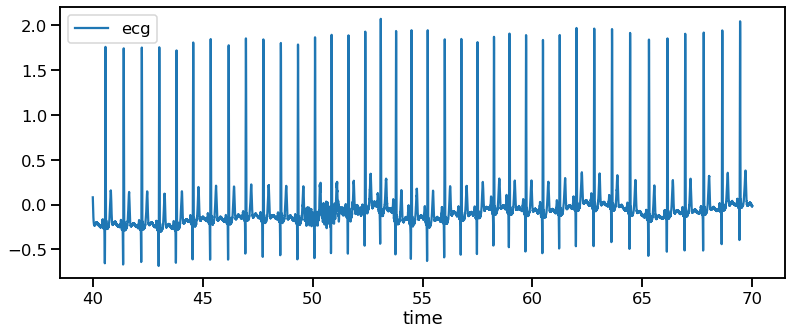

In [6]:
ecg_df[ecg_df.time.between(40, 70)].plot(x='time', y='ecg', figsize=(13, 5))

### R peaks detection

Because we will be interested in heart rate and its variability here, our first goal will be to detect the R peaks. We will use the `ecg_peaks()` function provided by Systole to perform R peak detection. This function is a simple wrapper for famous peaks detection algorithms that are implemented in the [py-ecg-detectors module](https://github.com/berndporr/py-ecg-detectors) (Porr & Howell, 2019). The detection algorithm can be selected via the `ecg_method` parameter, it should be among the following: `hamilton`, `christov`, `engelse-zeelenberg`, `pan-tompkins`, `wavelet-transform`, `moving-average`. In this tutorial, we will use the [pan-tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) as it is a fast and commonly used algorithm for QRS detection.

We first select a sample of the signal.

In [7]:
signal = ecg_df[ecg_df.time.between(500, 530)].ecg.to_numpy()  # Select the first minute of recording

Then, we apply the `ecg_peaks()` function to this sample.

In [8]:
signal, peaks = ecg_peaks(signal, method='pan-tompkins', sfreq=1000)

This function will output the resampled `signal` (this is only important if the sampling frequency of the input signal was different from 1000 Hz), and a `peaks` vector. The peaks vector has the same size than the input signal and is a boolean array (only contain 0/False and 1/True). The R peaks are encoded as 1 and the rest is set to 0. This vector can then be used to plot the detected R peaks on the input signal (panel **1** below). We can also use this vector to compute the distance between each R peaks (the R-R interval, see panel **2** below), which is used to measure the instantaneous heart rate (see panel **3** below).

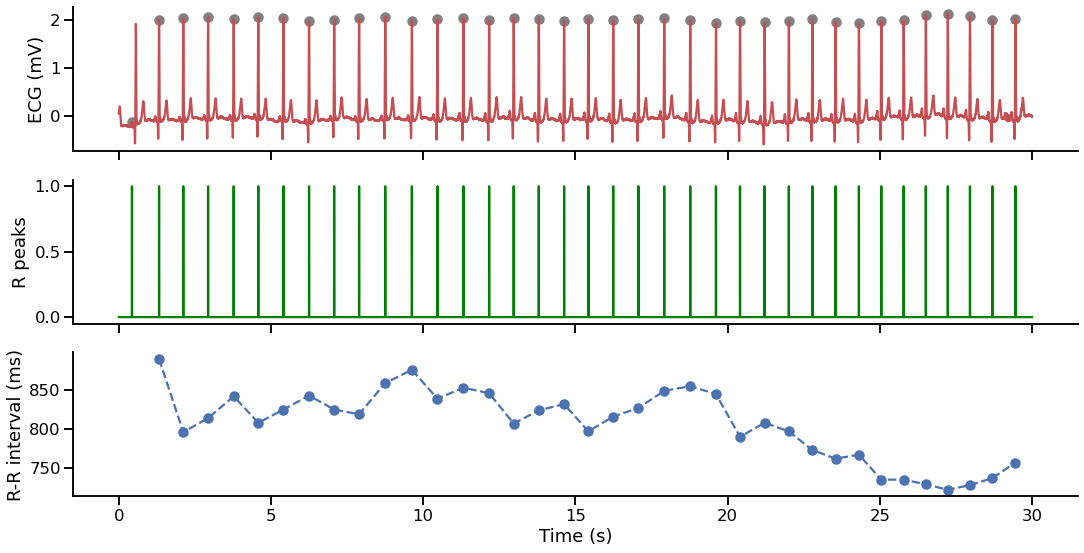

In [9]:
time = np.arange(0, len(signal))/1000

fig, axs = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

axs[0].plot(time, signal, color='#c44e52')
axs[0].scatter(time[peaks], signal[peaks], color='gray')
axs[0].set_ylabel('ECG (mV)')

axs[1].plot(time, peaks, color='g')
axs[1].set_ylabel('R peaks')

axs[2].plot(time[peaks][1:], np.diff(np.where(peaks)[0]), color='#4c72b0', linestyle='--')
axs[2].scatter(time[peaks][1:], np.diff(np.where(peaks)[0]), color='#4c72b0')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('R-R interval (ms)')
sns.despine()

### R-R intervals and beats per minute

The R-R intervals are expressed in milliseconds, but can also be converted into beats per minutes (BPM) using the following formula:
$$BPM = \frac{60000}{RR_{Intervals}} $$

It is worth noting that the conversion from RR intervals to beats per minute involves a non-linear function of the form $\frac{1}{x}$. This should be taken into account when interpreting the amplitude of heart rate increase/decrease with different baseline. For example, increasing the heart rate from 40 to 45 bpm diminish RR interval by approximately 167ms, while increasing the heart rate from 120 to 125 bpm decrease RR intervals by only 20ms (see graph below). While these differences have only marginal influence in most of the circumstances, this should be taken into account when measuring heart rate variability based on absolute RR interval difference, which is the case of some time-domain metric (e.g. the pNN50 or pNN20).

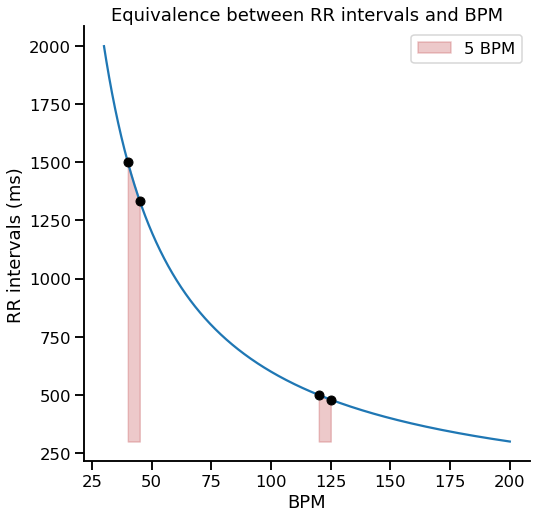

In [10]:
rr = np.arange(300, 2000, 2)
plt.figure(figsize=(8, 8))
plt.plot(60000/rr, rr)

plt.fill_between(x=np.arange(40, 46), y1=60000/np.arange(40, 46), y2=300, alpha=.3, color='#c44e52')
plt.plot([40, 45], 60000/np.array([40, 45]), 'ko')

plt.fill_between(x=np.arange(120, 126), y1=60000/np.arange(120, 126), y2=300, alpha=.3, color='#c44e52', label='5 BPM')
plt.plot([120, 125], 60000/np.array([120, 125]), 'ko')

plt.xlabel('BPM')
plt.ylabel('RR intervals (ms)')
plt.title('Equivalence between RR intervals and BPM')
plt.legend()
sns.despine()

### Interactive visualization

When using Systole, you can detect R peaks and plot the resulting ECG and R-R intervals times series with the `plot_raw()` function.

In [11]:
signal = ecg_df[ecg_df.time.between(500, 550)].ecg.to_numpy()

In [12]:
show(
    plot_raw(signal, modality='ecg', ecg_method='pan-tompkins', backend='bokeh')
)

We can see that, except for the first R peaks, the pan-tompkins algorithm seems to do a good job at detecting the QRS components. Looking at the R-R intervals time series, it is also obvious that the heart rate is not constant across time but oscillate according to lower frequencies. We will investigate these variations later in the section dedicated to heart rate variability bellow.

## Photoplethysmography (PPG)

[Photoplethysmography](https://en.wikipedia.org/wiki/Photoplethysmogram) is a non-invasive method used to measure the change of blood volume. The PPG signal is characterized by a main **systolic peak**, often (but not always) followed by a smaller **diastolic peaks** before the signal return to origin. The lower point between the systolic and diastolic peak is the **dicrotic notch**. The systolic peaks correspond to the moment where the volume of blood in the blood vessel suddenly increase due to the pressure of the heart contraction. The blood volume measured at the periphery does not change immediately after the cardiac systole, but rather with a delay varying depending on physiological parameters. For this reason, the systolic peak and the R peak are not concomitant but rather delayed, the systolic peak often occurring the T wave of the ECG. The delay between the R wave on the ECG and the systolic peak can vary between individuals and across time in the same individual.

In [13]:
Image(url='https://github.com/LegrandNico/Notebooks/raw/main/images/pulseOximeter.png', width=1200)

First, we import an example signal. This time serie represent a PPG recording from pulse oximeter in a young health participant. The sampling frequecy is 75 Hz (75 data points/seconds)

In [14]:
ppg = import_ppg()

### Systolic peak detection

The main information of interest we can retrieve from the PPG signal is the timing of occurrence of the systolic peak. The timing of these events is indeed tightly linked to the occurrence of the R wave (although with a slightly variable delay), and we can use the peak vector resulting from this analysis the same way we analyse the RR interval time-series with an ECG signal. Because we are not measuring the heart rate strictly speaking, but the pulse at the periphery of the body, this approach is often termed **pulse rate variability** to distinguish from the heart rate variability that builds on the ECG signal.

In [15]:
Image(url='https://github.com/LegrandNico/Notebooks/raw/main/images/ppgRecording.png', width=1200)

As before, you can plot the time serie and visualize peak detection and the inter beat interval time series using the `plot_raw` function.

In [16]:
show(
    plot_raw(ppg, backend='bokeh')
)

# References

[1] van Gent, P., Farah, H., van Nes, N., & van Arem, B. (2019). HeartPy: A novel heart rate algorithm for the analysis of noisy signals. *Transportation Research Part F: Traffic Psychology and Behaviour, 66, 368–378*. https://doi.org/10.1016/j.trf.2019.09.015 **This paper descries of a simple systolic peak detection algorithm and clipping artefacts correction**.

[2] Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time series artefact correction using novel beat classification. *Journal of Medical Engineering & Technology, 43(3), 173–181*. https://doi.org/10.1080/03091902.2019.1640306 **A method for artefact detection and artefact correction based on the first and second derivative of RR intervals**.

[3] Porr, B., & Howell, L. (2019). R-peak detector stress test with a new noisy ECG database reveals significant performance differences amongst popular detectors. Cold Spring Harbor Laboratory. https://doi.org/10.1101/722397 **Python implementation of famous R peak detection algorithms tested against large dataset**.

[4] Legrand, N., Etard, O., Vandevelde, A., Pierre, M., Viader, F., Clochon, P., Doidy, F., Peschanski, D., Eustache, F., & Gagnepain, P. (2020). Long-term modulation of cardiac activity induced by inhibitory control over emotional memories. Scientific Reports, 10(1). https://doi.org/10.1038/s41598-020-71858-2 **Task paradigm used to record the ECG dataset**.